# ***Image Generation with GANs (Generative Adversarial Networks)***

* #####  Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

* #####  They are a class of generative models that are based on the idea of training two networks, a generator and a discriminator, that compete with each other. The generator is trained to generate data that is indistinguishable from the real data, while the discriminator is trained to distinguish between real and generated data. The two networks are trained together in a minimax game, where the generator tries to fool the discriminator, and the discriminator tries to correctly classify the data.
* ##### Overall, the training process is a continuous game of cat and mouse; The generator learns to create more realistic images, The discriminator becomes better at detecting fake images. This adversarial process drives both networks to improve, ultimately leading to the generation of high-quality synthetic data.

### **Problem Representation**
* Problem: Generate high-quality synthetic images using a Generative Adversarial Network (GAN).
* Input: Random noise vector (latent vector) and real images from the MNIST dataset without their labels.
* Output: Synthetic images that resemble real images from the MNIST dataset.

**Main Steps**
1. Import Libraries
2. Load and Preprocess the Data
3. Build the Generator
4. Build the Discriminator
5. Train the GAN
6. Generate Synthetic Images
7. Visualize the Synthetic Images
8. Evaluation of the GAN

**Importing required dependencies**

In [32]:
import torch
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from IPython.display import Image, display
from torchvision.utils import save_image
import numpy as np
import os

**Loading the data**

* The tensor data are normalised to a range [-1,1] as the output layer of the Generator network is a tanh function.

In [2]:
#define the transformation to be applied to the images
transform = Compose(
    [
        ToTensor(), #converts the image to a tensor in the range [0,1]
        Normalize((0.5,), (0.5,)) #Normalise to [-1,1]
    ]
)

#loading the training dataset normalised to [-1,1]
mnist_dataset = MNIST(root='data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15382476.47it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 527360.21it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3868383.08it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8134299.22it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Viewing a random image tensor**

* This is to verify if the above transformations have been applied correctly.

In [3]:
img_num = np.random.randint(len(mnist_dataset)) #generate a random integer within the range of the dataset length
img, label = mnist_dataset[img_num] #extract the img_num+1 th image and its label
print(f"Label of image number {img_num}: ", label)
print(img[:, 10:15, 10:15]) #extract a 5x5 pixel region of the image starting from row 10 and column 10
torch.min(img), torch.max(img) #print the min and max values of the image tensor

Label of image number 14666:  6
tensor([[[ 0.9843,  0.7804, -0.5765, -1.0000, -1.0000],
         [ 0.9843,  0.2706, -1.0000, -1.0000, -1.0000],
         [ 0.9843, -0.4902, -1.0000, -1.0000, -1.0000],
         [ 0.4275, -0.9294, -1.0000, -1.0000, -1.0000],
         [ 0.7490, -0.8275, -1.0000, -1.0000, -1.0000]]])


(tensor(-1.), tensor(1.))

**Defining a function to denormalise images**

* This function is designed to denormalise an image tensor that has been normalised to the range [-1,1] back to its original range [0,1].
* The argument 'image' is assumed to have values within the range [-1,1].
* Then image+1 operation shifts the range to [0,2] and then division by 2 gives back the original range [0,1].
* The clamp(0,1) function ensures that all denormalised images are clipped to the range [0,1]. i.e. if any elements are less than 0, they are set to 0. If any elements are greater than 1, they are set to 1.

In [4]:
def denormalise(image):
    """
    Denormalises an image tensor from the range [-1, 1] to the range [0, 1].

    Args:
        image (torch.Tensor): The input image tensor with values in the range [-1, 1].

    Returns:
        torch.Tensor: The denormalised image tensor with values clamped to the range [0, 1].
    """
    denorm_img = (image + 1) / 2 #denormalise to [0,1]
    return denorm_img.clamp(0, 1) #clamp to range [0,1]

**Viewing a denormalised image**

Label:  6


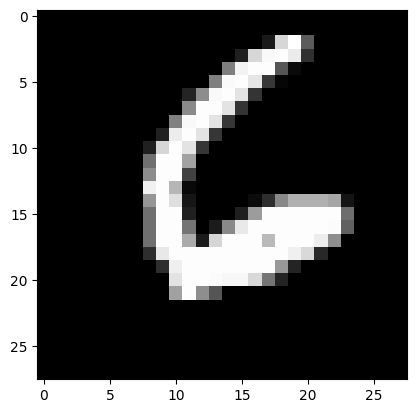

In [5]:
denorm_img = denormalise(img) #denormalise the image
plt.imshow(denorm_img[0], cmap='gray') #show the original image
print("Label: ", label)
plt.show()

**Creating a DataLoader object and verifying its functionality**

* The DataLoader object is created to load the MNIST dataset in batches.
* The DataLoader object is created with a batch size of 100 and shuffle=True.
* A random image of the first batch is displayed to verify that the DataLoader object is functioning correctly.

First batch - Image number 29
Image batch shape:  torch.Size([100, 1, 28, 28])


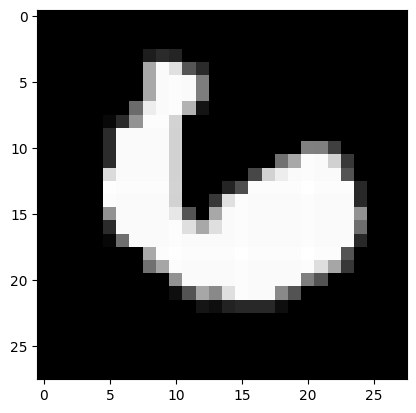

Label batch shape:  torch.Size([100])
Label: 6


In [6]:
batch_size = 100
#creating the DataLoader object
data_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

#exploring and verifying the first batch
img_num_in_batch = np.random.randint(batch_size) #generate a random integer within the range of the batch size
for image_batch, label_batch in data_loader: #iterate over the data_loader iterable
    print(f"First batch - Image number {img_num_in_batch}")
    print("Image batch shape: ", image_batch.shape) #image shape --> (batch_size, channels, height, width)
    plt.imshow(image_batch[img_num_in_batch][0], cmap='gray') #show the selected random image
    plt.show()
    print("Label batch shape: ", label_batch.shape) #label shape
    print(f"Label: {label_batch[img_num_in_batch]}")
    break #break as only the first batch is needed

**Creating a device variable**

* This can be used to move the data and models to a GPU if one is available.

In [7]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

**Defining the model architecture**

**1) Discriminator Network**

* Takes an image as input and tries to classify it as "Real" or "Fake/Generated".
* Here a simple Feed Forward Neural Network with 3 is used.
* LeakyReLU - Improves training stability, helps avoid dead neurons, and enhances the learning capability.

In [8]:
img_size = 784 #size of the input image (28x28)
hidden_size = 256 #size of the hidden layers

#creating the model architecture
discriminator = nn.Sequential(
    nn.Linear(img_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.3),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

discriminator.to(device) #move the discriminator model to the chosen device

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=256, out_features=1, bias=True)
  (7): Sigmoid()
)

**2) Generator Network**

* Input to a generator is a random noise vector z (latent vector/seed).
* Then it is transformed into a synthetic image.
* Here again a simple Feed Forward Neural Network is used.



In [9]:
latent_size = 64 #size of the latent vector

generator = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, img_size),
    nn.Tanh() #outputs are in the range [-1,1]
)

generator.to(device) #move the generator model to the chosen device

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

*Generating 2 images using the generator network to verify its functioning*


In [10]:
#create a vector of 2 images of shape (2,latent_size)
#where each image consists of random values sampled from a standard normal distribution (torch.randn)
latent_vector = torch.randn(size=(2, latent_size))
print("Latent vector shape: ", latent_vector.shape) #check the shape

y = generator(latent_vector)
print("Generator output shape: ", y.shape) #check the shape

y = y.reshape((-1, 28, 28)).detach() #reshape the generated images to (2,28,28)
#the detach() method ensures that the generated images are not tracked for further gradient updates
#(i.e used only for visualisation purposes)
print("Reshaped generator output shape: ", y.shape) #check the shape

gen_imgs = denormalise(y) #denormalise the generated images

Latent vector shape:  torch.Size([2, 64])
Generator output shape:  torch.Size([2, 784])
Reshaped generator output shape:  torch.Size([2, 28, 28])


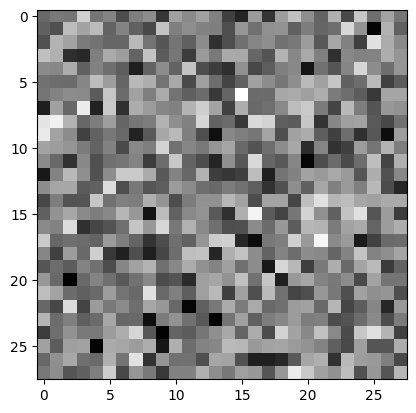

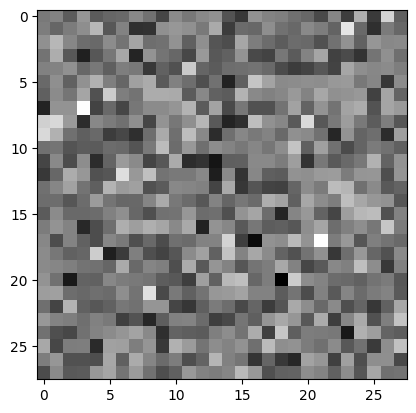

In [11]:
#viewing the generated images
for img in gen_imgs:
    plt.imshow(img, cmap='gray')
    plt.show()

**Defining the loss function and optimizer for discriminator and generator networks**

In [19]:
criterion = nn.BCELoss() #binary cross entropy loss for both generator and discriminator
lr = 0.0002 #learning rate
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr) #Adam optimizer FOR discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr) #Adam optimizer for generator

**Discriminator Training Function**

* The discriminator is a binary classification model. Therefore, Binary Cross Entropy is used as the loss function.

Steps involved:

1) The expectation from the discriminator is to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the Generator network.

2) First a batch of real images are passed and the loss is computed by setting the target labels to 1.

3) Then a batch of fake images are generated using the Generator and the loss is computed by setting the target label to 0.

4) Finally, the 2 losses are added and that is used to perform gradient descent to adjust weights of the "Discriminator".

**(Imp NOTE: Weights of the "Generator" network are not adjusted while training the "Discriminator").**

In [13]:
def train_discriminator(images):
    """
    Trains the discriminator network on a batch of real and fake images.

    Args:
        images (torch.Tensor): A batch of real images.

    Returns:
        tuple: A tuple containing:
            - discriminator_loss (torch.Tensor): The combined loss for real and fake images.
            - discriminator_real_score (torch.Tensor): The discriminator's predictions for the real images.
            - discriminator_fake_score (torch.Tensor): The discriminator's predictions for the fake images.
    """
    #Step1: creating labels
    real_labels = torch.ones(size=(batch_size, 1)).to(device) #labels for real images
    fake_labels = torch.zeros(size=(batch_size, 1)).to(device) #labels for fake/generated images

    #Step2: loss for real images
    preds_real = discriminator(images) #predictions of discriminator network for a batch of images
    discriminator_real_loss = criterion(preds_real, real_labels) #loss for real images
    discriminator_real_score = preds_real #score for real images

    #Step3: loss for fake images
    latent_vector = torch.randn(size=(batch_size, latent_size)).to(device) #latent vector for fake images
    fake_imgs = generator(latent_vector) #fake images
    preds_fake = discriminator(fake_imgs) #predictions of discriminator network for a batch of fake images
    discriminator_fake_loss = criterion(preds_fake, fake_labels) #loss for fake images
    discriminator_fake_score = preds_fake #score for fake

    #Step4: combining the losses
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss

    #Step 4 update gradients (only for discriminator)
    discriminator_optimizer.zero_grad() #reset gradients
    discriminator_loss.backward() #compute gradients
    discriminator_optimizer.step() #update weights using backpropagation

    return discriminator_loss, discriminator_real_score, discriminator_fake_score


**Generator Training Function**

* The generator creates a batch of synthetic images. (The problem of relating images to a loss function arises!)
* The goal of the generator is to fool the discriminator, so the target label is set to 1 in all these generated images. (We want the discriminator to believe it is real)
* The discriminator takes these generated images and assigns a probability to each image.
* The loss function calculates the difference between this predicted probability and the target labels(1). A HIGH loss indicates the discriminator is performing WELL !.
* Then this loss is used to update weights of the generator through back propagation. This process adjusts its parameters to produce images that are more likely to deceive the discriminator.

In [14]:
def train_generator():
    """
    Trains the generator network for one iteration.

    Steps:
    1. Creates labels for fake images (set to 1 to deceive the discriminator).
    2. Generates fake images using a latent vector.
    3. Computes the predictions of the discriminator for the fake images.
    4. Calculates the loss for the fake images.
    5. Updates the generator's parameters using backpropagation.

    Returns:
        tuple: A tuple containing the generator loss and the generated fake images.
    """
    #Step1: creating labels
    labels = torch.ones(size=(batch_size, 1)).to(device) #labels for fake images are set as 1 to deceive the discriminator

    #Step2: Generate fakes
    latent_vector = torch.randn(size=(batch_size, latent_size)).to(device) #latent vector for fake images
    fakes = generator(latent_vector) #generate fake images
    preds_fakes = discriminator(fakes) #predictions of discriminator network for a batch of fake images

    #Step3: loss for fake images
    generator_loss = criterion(preds_fakes, labels) #loss for fake images

    #Step4: Updating generator parameters
    generator_optimizer.zero_grad() #reset gradients
    generator_loss.backward() #compute gradients
    generator_optimizer.step() #update weights using backpropagation

    return generator_loss, fakes

**Training the Model**

*Creating a directory to store generated images*

In [15]:
samples_dir = 'generated_samples & comparison samples'
#create the specified directory if it does not already exist
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)

*Save a batch of real images to a single image for visual comparison with the generated images*

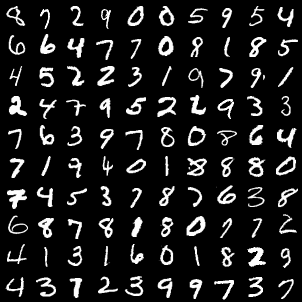

In [16]:
for images, _ in data_loader: #iterate over the data_loader iterable
    images = images.reshape(images.size(0), 1, 28, 28) #reshape the image tensor to (batch_size, channels, height, width)
    save_image(denormalise(images), os.path.join(samples_dir, 'real_images.png'), nrow=10) #save the image as a 10x10 grid of real images
    break #break as only the first batch is needed

Image(filename=os.path.join(samples_dir, 'real_images.png')) #display the image

*This function saves the generated images after each epoch in the specified directory*


- The function reshapes the input tensor to ensure it has the correct dimensions
    for saving.
- The images are saved in a 10x10 grid format.
- The images are denormalized before saving.
- The saved images are named using the epoch number to ensure uniqueness.

In [17]:
def save_generated_imgs(epoch, fake_imgs):
    """
    Save generated images to disk.

    Args:
        epoch (int): The current epoch number, used to create unique image filenames.
        fake_imgs (torch.Tensor): A batch of generated images, expected to be a 4D tensor
                                  with shape (batch_size, channels, height, width).

    Returns:
        None
    """
    fake_imgs = fake_imgs.reshape(fake_imgs.size(0),1, 28, 28) #reshape the image tensor to (batch_size, channels, height, width)
    path_name = "Fake_Img {0:0=4d}.png".format(epoch) #create unique image names
    print(f"Saving... {path_name}")
    save_image(denormalise(fake_imgs), os.path.join(samples_dir, path_name), nrow=10) #save the image as a 10x10 grid of generated images

*Training the model*

* In each epoch, the generator is trained ***first*** and then the discriminator.
* After each epoch, the **save_generated_imgs** is called to save the generated image.

In [21]:
%%time

num_epochs = 200
total_steps = len(data_loader) #number of batches in the data_loader > In this case step = 60,000/batch_size = 600

discriminator_losses, generator_losses, real_scores, fake_scores = [], [], [], [] #lists to store the losses and scores

for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(data_loader):
        #the discriminator requires flattened vectors to work
        images = images.reshape(batch_size, -1).to(device) #reshape the image tensor to (batch_size, img_size)

        #train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        #train the generator
        g_loss, fake_imgs = train_generator()

        #inspect losses after every 200 steps
        if (batch_idx+1) % 200 == 0:
            #populate the loss and score arrays - item() converts pytorch tensor objects to regular scalars
            discriminator_losses.append(d_loss.item())
            generator_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())

            #print the progress of the model
            print(
                f"Epoch: [{epoch}/{num_epochs}], Step: [{batch_idx+1}/{total_steps}], "
                f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
                f"D Real Score: {real_score.mean().item():.4f}, "
                f"D Fake Score: {fake_score.mean().item():.4f} "
            )

    #save generated images
    save_generated_imgs(epoch+1, fake_imgs)

Epoch: [0/200], Step: [200/600], D Loss: 1.3396, G Loss: 0.7481, D Real Score: 0.5432, D Fake Score: 0.4811 
Epoch: [0/200], Step: [400/600], D Loss: 1.2862, G Loss: 0.8948, D Real Score: 0.5290, D Fake Score: 0.4385 
Epoch: [0/200], Step: [600/600], D Loss: 1.2304, G Loss: 0.9100, D Real Score: 0.5628, D Fake Score: 0.4357 
Saving... Fake_Img 0001.png
Epoch: [1/200], Step: [200/600], D Loss: 1.2860, G Loss: 0.7828, D Real Score: 0.5554, D Fake Score: 0.4683 
Epoch: [1/200], Step: [400/600], D Loss: 1.3335, G Loss: 0.7172, D Real Score: 0.5610, D Fake Score: 0.4947 
Epoch: [1/200], Step: [600/600], D Loss: 1.2638, G Loss: 0.9242, D Real Score: 0.5226, D Fake Score: 0.4230 
Saving... Fake_Img 0002.png
Epoch: [2/200], Step: [200/600], D Loss: 1.3065, G Loss: 0.7810, D Real Score: 0.5169, D Fake Score: 0.4186 
Epoch: [2/200], Step: [400/600], D Loss: 1.3441, G Loss: 0.7778, D Real Score: 0.5520, D Fake Score: 0.4875 
Epoch: [2/200], Step: [600/600], D Loss: 1.1926, G Loss: 0.8639, D Real 

**Evaluation**

*This cell displays the generated images after every 50 epochs.*

Displaying  generated_samples & comparison samples/Fake_Img 0050.png


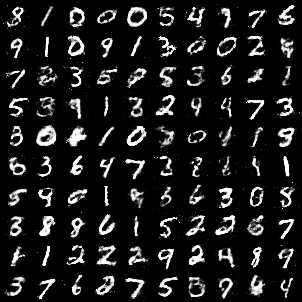


Displaying  generated_samples & comparison samples/Fake_Img 0100.png


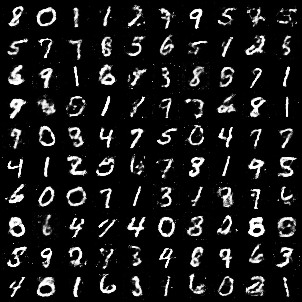


Displaying  generated_samples & comparison samples/Fake_Img 0150.png


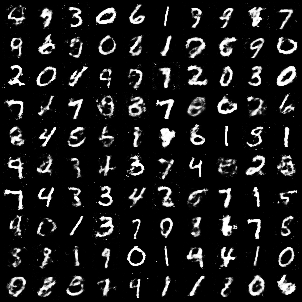


Displaying  generated_samples & comparison samples/Fake_Img 0200.png


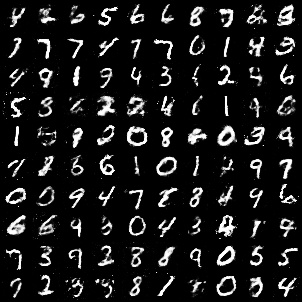

In [36]:
i = 50 #start from 50th epoch
while i <= num_epochs: #loop until the num_epochs
    file_path = os.path.join(samples_dir, "Fake_Img {0:0=4d}.png".format(i))
    print("Displaying ", file_path)
    display(Image(filename=file_path))
    print()
    i += 50 #makes sure images after every 50 epochs are displayed

*Visualising the loss change over epochs.*

* This is useful to adjust hyperparameters during re-training
* The expectation is for the generator loss to reduce over time without the discriminator loss getting too high

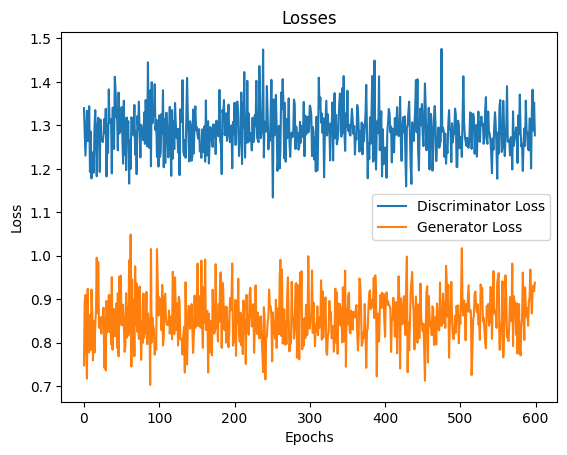

In [29]:
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses')
plt.show()

*Visualising the scores over time*

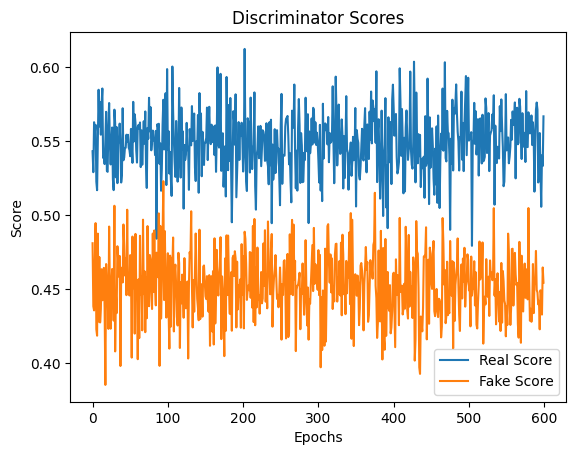

In [30]:
plt.plot(real_scores, label='Real Score')
plt.plot(fake_scores, label='Fake Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Discriminator Scores')
plt.show()

Concluding Note for further improvement: A better result could have been obtained if the networks had CNN layers without a basic Feed Forward Network.